In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [3]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_path=Path()/'datasets'/'titanic'

In [5]:
data_train_orig = pd.read_csv(data_path/'train.csv')
data_train= data_train_orig.copy()
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# X_test = pd.read_csv('/kaggle/input/titanic/test.csv')
X_test = pd.read_csv(data_path/'test.csv')

In [7]:
y = data_train['Survived']
cols = data_train.columns.tolist()
cols.remove('Survived')
X_train = data_train[cols]
# X_train = X_train.set_index('PassengerId')
# X_test = X_test.set_index('PassengerId')
# X_train.head()

In [8]:
# Explore the data
# Name, Sex, Ticket, Cabin, Embarked are categorical data and the others are numerical ones
# Total 891 records and Age and Cabin have missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# Missing data Need strategy for interpolating miss age
((data_train.isnull().sum())/len(data_train))*100


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [10]:
def get_missing_value_columns(df):
    """get missing value columns list """
    return df.columns[df.isnull().any()].to_list()


In [11]:
get_missing_value_columns(data_train_orig)

['Age', 'Cabin', 'Embarked']

In [12]:
# 38% passagers are survived, and average is around 30
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
# check the unique values
data_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [14]:
# Split numerical/categorical data
numerics = ['int64','float64']
num_ones = data_train.select_dtypes(numerics)
num_ones = data_train.select_dtypes(include=np.number)
cat_ones = data_train.select_dtypes(include=['object'])
num_ones = num_ones.drop('PassengerId', axis=1)
num_ones.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [15]:
data_train[['Age','Sex']].groupby(['Sex']).agg(['mean',  'median'])

Age       
             mean median
Sex                     
female  27.915709   27.0
male    30.726645   29.0

<AxesSubplot: xlabel='AgeBucket'>

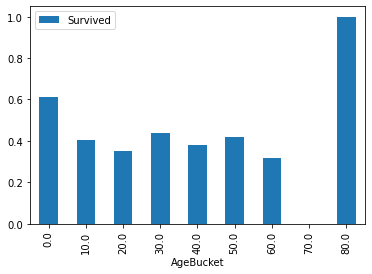

In [16]:
data_train['AgeBucket'] = data_train['Age']//10*10
data_train[['AgeBucket','Survived']].groupby(['AgeBucket']).mean().plot(kind='bar')
# baby, eldest person and middle age comparably having higer survivor

## Univariate Analysis

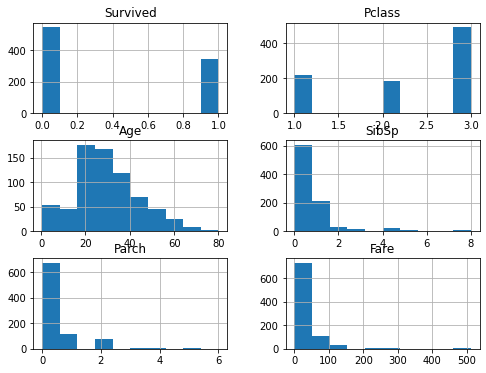

In [17]:
num_ones.hist(figsize=(8,6))
plt.show()
# Pclass. more people in class three
# Age: there existed kids with their family member, as well as some elder people (kids with family may have high chances to survive)
# sibsp # of siblings / spouses aboard the Titanic: most people don't while over 25% had siblings/spouse in the ship
# Parch: even around 1/4 are parch, may they survive with high probablity?
# Fare: most people are free or cheap ones(ship crews)

Survived
Skew: 0.48


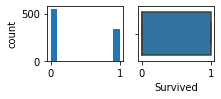

Pclass
Skew: -0.63


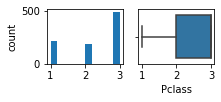

Age
Skew: 0.39


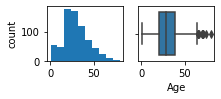

SibSp
Skew: 3.7


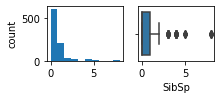

Parch
Skew: 2.75


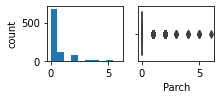

Fare
Skew: 4.79


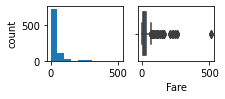

In [18]:
# numerical one: susing hist, boxplot, density plot
# todo: change to horizontal ones
for col in num_ones.columns:
    print(col)
    print('Skew:', round(data_train[col].skew(),2))
    plt.figure(figsize=(3,1))
    plt.subplot(1,2,1)
    data_train[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data_train[col])
    plt.show()

In [19]:
# replace Parch and Sibsp with their sum for they may family, it seems total 1-3 relatives are likely to survive 
data_train['RelativesOnboard'] = data_train['SibSp'] + data_train['Parch']
data_train[['RelativesOnboard','Survived']].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


1    0.495098
2    0.186275
3    0.024510
4    0.014706
Name: Cabin, dtype: float64

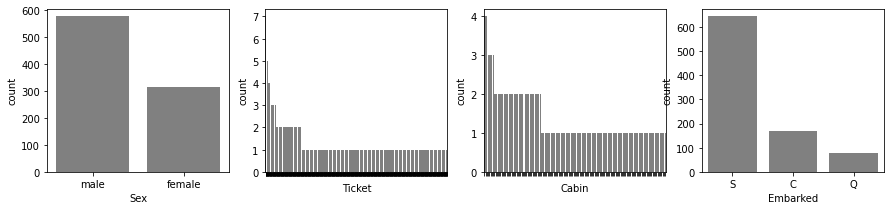

In [20]:
# Categorical one:count plot, bar plot, pie plot
fig, axes = plt.subplots(1,4,figsize=(15,3))
for num,col in enumerate(['Sex','Ticket','Cabin','Embarked']):

    sns.countplot(ax=axes[num], x=col,data=data_train, color='grey',
                 order=data_train[col].value_counts().index)
    if col in ['Ticket','Cabin']:
        axes[num].set_xticklabels("")

# almost 60% are male
# over 60% passanger embarked at S
# around 50%  people live in unique cabin
# around 61% passager took unique ticket and 10% shared pair ticket
data_train['Cabin'].value_counts().value_counts()/data_train['Cabin'].value_counts().values.sum()

In [21]:
data_train['Ticket'].value_counts().value_counts()/data_train['Ticket'].value_counts().values.sum()

1    0.613917
2    0.105499
3    0.023569
4    0.012346
7    0.003367
6    0.003367
5    0.002245
Name: Ticket, dtype: float64

In [22]:
# add ticket value counts and cabin value counts as new columns and see wheter that have correlation with the Pclass, fare and survived

data_train['TicCount'] = data_train.groupby('Ticket')['Ticket'].transform('count')

In [23]:
cabin_count = data_train['Cabin'].value_counts()
data_train['CabCount'] = data_train['Cabin'].apply(lambda x: 0 if pd.isnull(x) else cabin_count[x])


In [24]:
# Try to create new feature Title
import re
def get_title(name):
    title = re.search('([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ""

In [25]:
data_train['Title']=data_train['Name'].apply(get_title)

In [26]:
print(data_train[['Title','Survived']].groupby('Title').mean().sort_values(by='Survived',ascending=False))
data_train['Title'].value_counts()
# sir,Countess,Ms ,Mme,Lady,Mlle is clustered as ‘distinguished' and left <40 as remain

          Survived
Title             
Sir       1.000000
Countess  1.000000
Ms        1.000000
Mme       1.000000
Lady      1.000000
Mlle      1.000000
Mrs       0.792000
Miss      0.697802
Master    0.575000
Col       0.500000
Major     0.500000
Dr        0.428571
Mr        0.156673
Jonkheer  0.000000
Don       0.000000
Rev       0.000000
Capt      0.000000


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [27]:
def get_title(name):
    title = re.search('([A-Za-z]+)\.', name)
    if title:
        title = title.group(1)
        if title in ('sir','Countess','Ms' ,'Mme','Lady','Mlle'):
            title ='Noble'
        elif title not in ('Mr','Miss','Mrs','Master '):
            title ='Others'
    else: title =None
    return title

In [28]:
data_train['Title']=data_train['Name'].apply(get_title)
print(data_train[['Title','Survived']].groupby('Title').mean().sort_values(by='Survived',ascending=False))
data_train['Title'].value_counts()

        Survived
Title           
Noble   1.000000
Mrs     0.792000
Miss    0.697802
Others  0.475410
Mr      0.156673


Mr        517
Miss      182
Mrs       125
Others     61
Noble       6
Name: Title, dtype: int64

## Bivariate exploration

In [29]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,TicCount,CabCount,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20.0,1,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1,1,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20.0,0,1,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1,2,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0,1,0,Mr


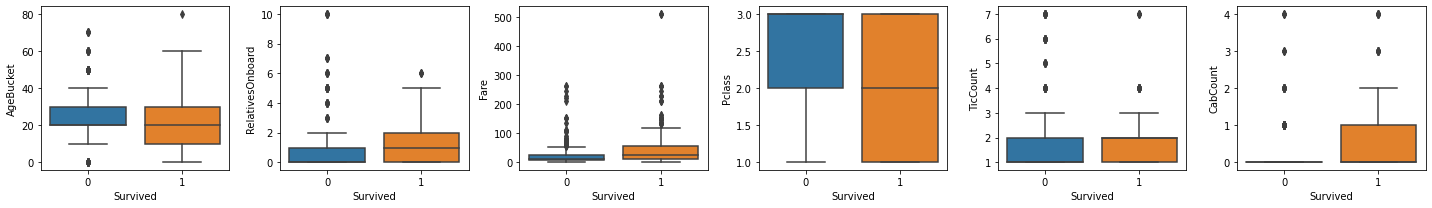

In [30]:
# explore the relationship between numerical ones and survived by boxplot plot(also could be viloin, count, swarm and bar plots)
cols=['AgeBucket','RelativesOnboard','Fare','Pclass','TicCount','CabCount']

_, axes = plt.subplots(1,6, figsize=(20,3))
for num, col in enumerate(cols): 
    sns.boxplot(ax=axes[num], x='Survived', y=col, data=data_train)
plt.tight_layout()
    
# kids, small family members(mother with kids). richer people are more likely to survive, people without cabin who may crew  did not survive

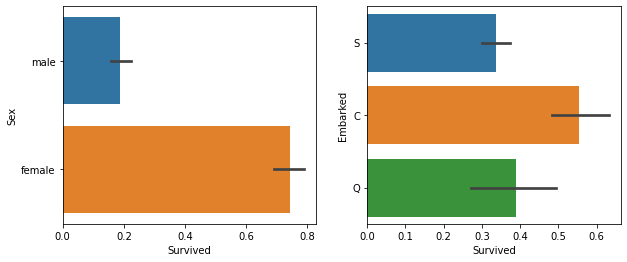

In [31]:
# explore the relationship between categorical one and survived by count plot
cols=['Sex','Embarked']
_, axes = plt.subplots(1,len(cols), figsize=(10,4))
for num, col in enumerate(cols): 
    sns.barplot(ax=axes[num], x='Survived', y=col,data=data_train)
    
# female and people embarked from c are more likey to survival even more people were on board from s

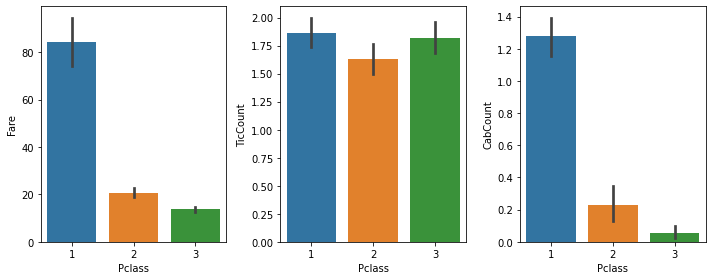

In [32]:
cols=['Fare','TicCount','CabCount']
_, axes = plt.subplots(1,len(cols), figsize=(10,4))
for num, col in enumerate(cols): 
    sns.barplot(ax=axes[num], x='Pclass', y=col,data=data_train)
plt.tight_layout()

#  Pclass as 1 passanger have more 1 cabin while the others shared cabin

* Need to fix missing age 

<AxesSubplot: >

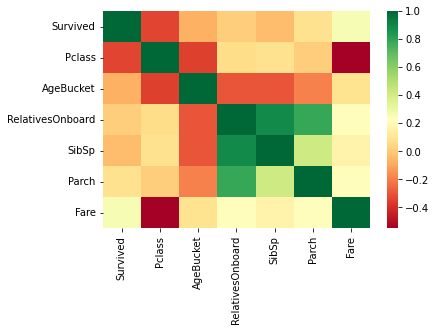

In [33]:
num_ones =data_train[['Survived', 'Pclass', 'AgeBucket','RelativesOnboard', 'SibSp', 'Parch', 'Fare']]
sns.heatmap(num_ones.corr(), cmap='RdYlGn')

In [34]:
corr_matrix = num_ones.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived            1.000000
Fare                0.257307
Parch               0.081629
RelativesOnboard    0.016639
SibSp              -0.035322
AgeBucket          -0.073029
Pclass             -0.338481
Name: Survived, dtype: float64

## Prepare the data
1. fix the missing age, embarked
2. Create new feature 'AgeBucket','RelativesOnboard','TicCount','CabCount','Title'
3. Standardize the number features: Fare
4. OneHotEncoding categorical features: Sex, embarked
5. Using customerised transformer to fufill step 2 or using function to fulfill all

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [36]:
def column_value_counts(X):
    x_count = X.value_counts()
#     return X.apply(lambda x: x_count[x])
    return X.apply(lambda x: 0 if pd.isnull(x) else x_count[x])

def column_combined(X1, X2): 
    return np.add(X1,X2)

def get_additional_features(df):
    #get title
    df['Title'] = df['Name'].apply(get_title)
    
    #get TicCount, Cabcount
    for col in ['Ticket', 'Cabin']:
        df[col+'Count'] = column_value_counts(df[col])
        
    #get RelativesOnboard
    df['RelativesOnboard'] = column_combined(df['SibSp'],df['Parch']) 
    return df
    
    
def dealing_with_missing_data(df):
    for col in ['Age', 'Fare']:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in ['Pclass', 'Embarked']:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    return df    
    

In [37]:
data_train_orig = pd.read_csv(data_path/'train.csv')
data_train = data_train_orig.copy()

data_train = dealing_with_missing_data(data_train)

get_missing_value_columns(data_train)

['Cabin']

In [38]:
data_train = dealing_with_missing_data(data_train)
data_train = get_additional_features(data_train)

In [39]:
num_cols=['Pclass','Age','Fare','RelativesOnboard','TicketCount', 'CabinCount']
cat_cols =['Title','Sex','Embarked']

In [40]:
num_pipeline= make_pipeline(
    StandardScaler()
)
cat_pipeline =make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessing = ColumnTransformer([
    ('num', num_pipeline,num_cols),
    ('col', cat_pipeline,cat_cols)
])

In [41]:
data_train_prepared = preprocessing.fit_transform(data_train)

In [42]:
data_train_prepared.shape

(891, 16)

In [43]:
def data_preprocessing(df):
    df_copy = df.copy()
    df_copy = dealing_with_missing_data(df_copy)
    df_copy = get_additional_features(df_copy)
    return df_copy


In [44]:
X_test_updated=data_preprocessing(X_test)
X_test_prepared = preprocessing.fit_transform(X_test_updated)




In [45]:
X_test_prepared.shape

(418, 16)

In [79]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 18.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Make Model

In [80]:
# using random forest tree

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [59]:
random_state= 42
rdm_tree = RandomForestClassifier( max_depth=5, random_state=random_state)
svc_rbf = SVC(gamma='auto',random_state=random_state)
lr =LogisticRegression(solver='liblinear',multi_class='auto',random_state=random_state)
dt = DecisionTreeClassifier(random_state= random_state)
knn =K

0.8316364321134895

In [48]:
rdm_tree = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rdm_tree.fit(data_train_prepared, y)

RandomForestClassifier(max_depth=5, random_state=42)

In [49]:
y_predict =rdm_tree.predict(data_train_prepared)
print("Classification report:\n\n{}".format(classification_report(y, y_predict)))

Classification report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       549
           1       0.82      0.76      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.85      0.84       891



In [55]:
precision_score(y_predict, y), recall_score(y_predict, y)

(0.7602339181286549, 0.8227848101265823)

In [50]:
predictions = rdm_tree.predict(X_test_prepared)

In [57]:
crv_score =cross_val_score(rdm_tree,data_train_prepared,y, cv=5)
crv_score.mean()

In [77]:
lsvc = LinearSVC(random_state=42, C=100, max_iter=1000)
crv_score =cross_val_score(lsvc,data_train_prepared,y, cv=5)
crv_score.mean()

TypeError: __init__() got an unexpected keyword argument 'solver'

In [146]:
output = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived':predictions})
output.to_csv(data_path/'submission.csv', index=False)
print('submission was successfully saved!')

submission was successfully saved!


In [142]:
X_test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [71]:
data_train_prepared[1]

array([-1.56610693,  0.66386103,  0.78684529,  0.05915988, -0.57916179,
        0.7468585 ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ])